# Infinite-$n$ ideal ballooning stability optimization

<font size="4">
This tutorial demonstrates how to evaluate and optimize an equilibrium for infinite-$n$ ideal-ballooning stability with DESC.
The infinite-$n$ ideal ballooning equation is

$$
\mathbf{B} \cdot \nabla \left( \frac{|\nabla \alpha|^2}{B^2} \mathbf{B} \cdot \nabla X \right) + 2 \frac{d \mu_0 p}{d\psi} \left[\mathbf{B} \times (\mathbf{b} \cdot \nabla \mathbf{b})\right] \cdot \nabla \alpha\, X = \gamma \frac{|\nabla \alpha|^2}{B^2} X, \quad \gamma = -\omega^2
$$

where $X$ is the ballooning eigenfunction whereas $\gamma$ is the ballooning eigenvalue. When $\gamma > 0$, the mode is ballooning-unstable, otherwise it is ballooning-stable. The equation is solved subject to Dirichlet boundary conditions on the eigenfunction $X$

$$X(\zeta = \zeta_1) = 0, X(\zeta = \zeta_2) = 0$$

where $\zeta_1$ and $\zeta_2$ are endpoints of the domain in ballooning space (a transformed covering space where $\zeta \in [0, 2\pi]$ to $\zeta \in [-\infty, \infty]$). Note that the ballooning $\zeta$ is technically a different coordinate than periodic $\zeta$

Numerically, this equation becomes a 1D EVP (eigenvalue problem) along a field line. 

$$ \frac{d}{d\zeta} \left(g \frac{dX}{d\zeta} \right) + c X = \gamma f X$$

where 

$$
\begin{eqnarray}
    \text{g} &=& (\mathbf{b} \cdot \nabla \zeta) \frac{|\nabla \alpha|^2}{B}, \\
    \text{c} &=& \frac{1}{B^2} \frac{d(\mu_0 p)}{d\psi} \frac{2}{(\mathbf{b} \cdot \nabla \zeta)} (\mathbf{b} \times (\mathbf{b} \cdot \nabla \mathbf{b})) \times \nabla \alpha, \\
    \text{f} &=& \frac{1}{(\mathbf{b} \cdot \nabla \zeta)} \frac{|\nabla \alpha|^2}{B^3},
\end{eqnarray}
$$

are functions of $\zeta$ along a field line.
</font>

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines. 

In [2]:
# from desc import set_device
# set_device("gpu")

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import desc
from desc.grid import Grid, LinearGrid
from desc.optimize import Optimizer
from desc.objectives import (
    ForceBalance,
    AspectRatio,
    FixIota,
    FixPressure,
    FixPsi,
    PrincipalCurvature,
    BallooningStability,
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    GenericObjective,
)

plt.rcParams["font.size"] = 14

DESC version 0.12.1+809.gf688fb759.dirty,using JAX backend, jax version=0.4.24, jaxlib version=0.4.24, dtype=float64
Using device: CPU, with 16.41 GB available memory


## Evaluating ballooning stability of the initial equilibrium

In this section, we will show how you can take a DESC or VMEC equilibrium and evaluate its ballooning stability using DESC
You have to specify the normalized distance $\rho$ and the field line label $\alpha$ on which you want to solve the ballooning equation. 

DESC will solve the ballooning equation on multiple field lines on each flux surface and output the maximum ballooning growth rate on each flux surface. 

$$ \gamma_{\rho, \mathrm{max}} = \mathrm{max}_{\alpha}(\gamma_{\rho, \alpha}), \quad \forall \quad \alpha \in [0, \pi]$$


In [4]:
# Importing the HELIOTRON DESC equilibrium
eq0 = desc.examples.get("HELIOTRON")

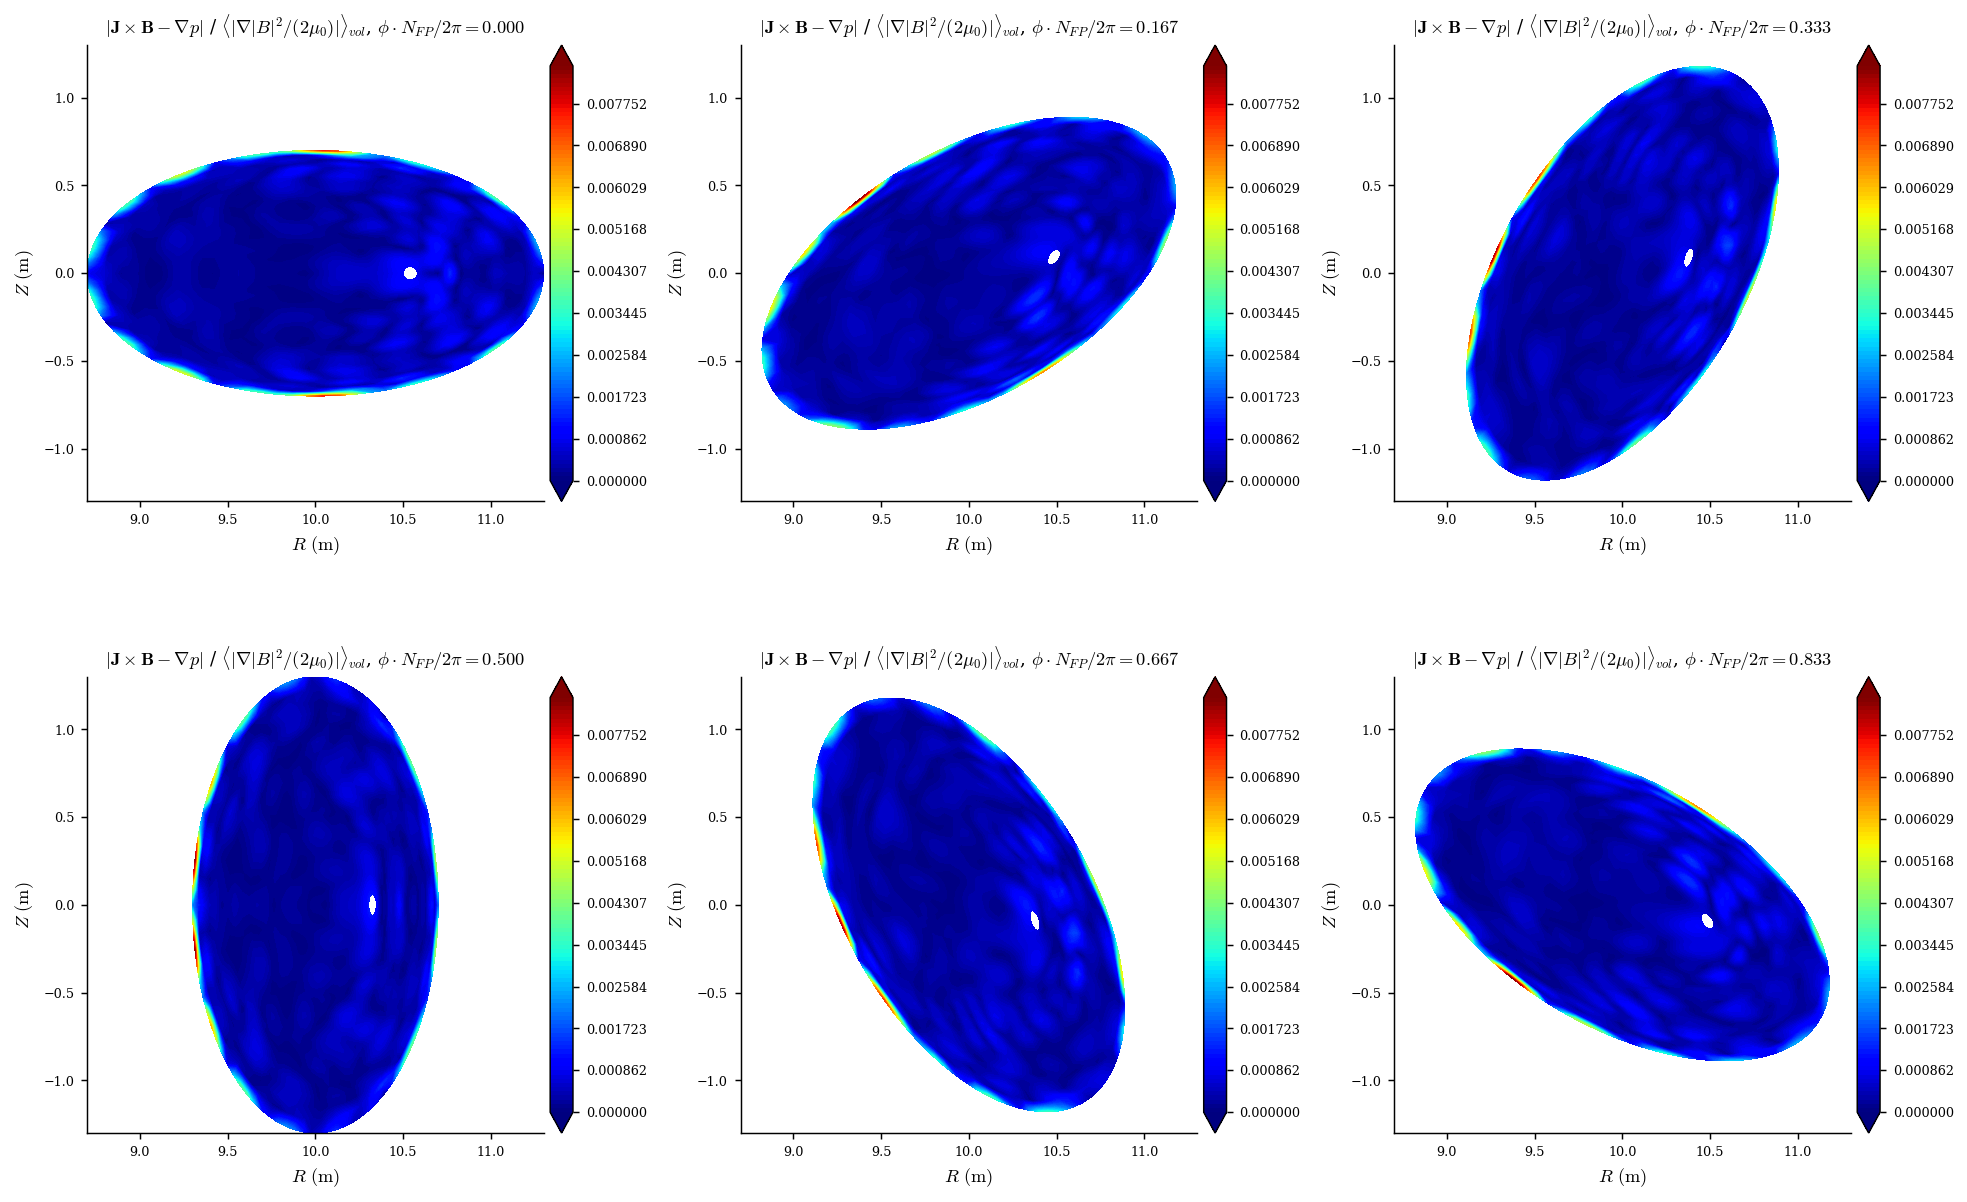

In [5]:
desc.plotting.plot_section(eq0, name="|F|", norm_F=True);

In [6]:
# Flux surfaces on which to evaluate ballooning stability
surfaces = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

nalpha = 8  # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = np.linspace(0, np.pi, nalpha, endpoint=False)

# Number of toroidal transits of the field line
nturns = 3

# Number of point along a field line in ballooning space
N0 = nturns * 200

# range of the ballooning coordinate zeta
zeta = np.linspace(-np.pi * nturns, np.pi * nturns, N0)

gamma_max0 = np.zeros(len(surfaces))

for j in range(len(surfaces)):
    rho = surfaces[j]

    # we need to make a special grid in field aligned coordinates, which we do here
    # coordinates="raz" tells desc that this grid is in rho,alpha,zeta coordinates
    # and period says that it is periodic in alpha but not in rho/zeta (along a field line
    # things are not generally periodic in zeta unless iota is rational)
    grid = Grid.create_meshgrid(
        [rho, alpha, zeta], coordinates="raz", period=(np.inf, 2 * np.pi, np.inf)
    )
    ball_data0 = eq0.compute(["ideal ball gamma2"], grid=grid)

    gamma_max0[j] = np.max(ball_data0["ideal ball gamma2"])
    print(f"surf number {j} done!")

print("Growth rate calculation finished!")

surf number 0 done!
surf number 1 done!
surf number 2 done!
surf number 3 done!
surf number 4 done!
surf number 5 done!
surf number 6 done!
Growth rate calculation finished!


## Plotting the maximum ballooning growth rate

After finishing an optimization, we plot the maximum ballooning growth rate $\gamma_{\mathrm{max}}$ on the chosen flux surfaces.

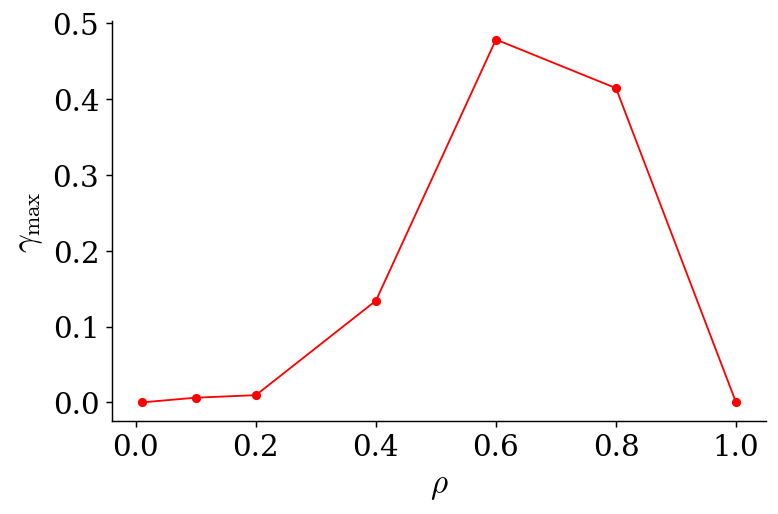

In [7]:
plt.plot(np.array(surfaces), gamma_max0, "-or", ms=4)
plt.xlabel(r"$\rho$", fontsize=18)
plt.ylabel(r"$\gamma_{\mathrm{max}}$", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

Note that the ballooning instability is driven by a pressure gradient. In the edge, if $p = 0$ but $dp/d\rho \neq 0$, we can still have a finite ballooning growth rate.
As a corollary, for vacuum equilibria or on equilibria with $dp/d\rho = 0$, the ballooning growth rate $\gamma <= 0$


## Aside: Newcomb's metric, A faster proxy for ballooning stability

<font size="4">
To expedite the stability calculation even further, we can use the Newcomb metric instead. It uses the Slurm oscillation theorem to determine whether an equilibrium is stable or unstable. However, the growth rate information or eigenfunction information is not calculated.
But since the calculation is faster than an eigenvalue solve, we can determine the stability of an equilibrium.

This idea is explained in much more detail in Appendix D of [Gaur _et al._](https://doi.org/10.1017/S0022377823000107)
</font>

In [8]:
# Flux surfaces on which to evaluate ballooning stability
surfaces = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

nalpha = 8  # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = np.linspace(0, np.pi, nalpha, endpoint=False)

# Number of toroidal transits of the field line
nturns = 3

# Number of point along a field line in ballooning space
N0 = nturns * 200

# range of the ballooning coordinate zeta
zeta = np.linspace(-np.pi * nturns, np.pi * nturns, N0)

Newcomb_ball_metric0 = np.zeros(len(surfaces))

for j in range(len(surfaces)):
    rho = surfaces[j]

    grid = Grid.create_meshgrid(
        [rho, alpha, zeta], coordinates="raz", period=(np.inf, 2 * np.pi, np.inf)
    )
    ball_data0 = eq0.compute(["Newcomb ball metric"], grid=grid)

    Newcomb_ball_metric0[j] = np.max(ball_data0["Newcomb ball metric"])
    print(f"surf number {j} done!")

print("Newcomb ball calculation finished!")

surf number 0 done!
surf number 1 done!
surf number 2 done!
surf number 3 done!
surf number 4 done!
surf number 5 done!
surf number 6 done!
Newcomb ball calculation finished!


### Plotting Newcomb's metric

<font size="4">
A newcomb metric value greater than zero implies stability whereas any value less than zero implies instability.
</font>

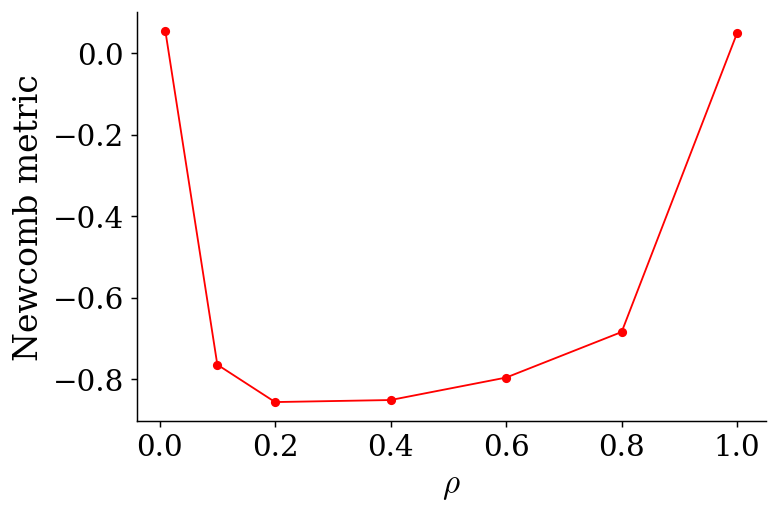

In [9]:
plt.plot(np.array(surfaces), Newcomb_ball_metric0, "-or", ms=4)
plt.xlabel(r"$\rho$", fontsize=18)
plt.ylabel("Newcomb metric", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

## Optimizing for ballooning stability

<font size="4">
Next, we explain how to take an existing ballooning unstable equilibirum and optimize it for ideal ballooning stability using DESC. The process is similar to other tutorials where you add the ballooning objective to the list of objective functions.
</font>

In [10]:
# save a copy of original for comparison
eq1 = eq0.copy()

nalpha = 8  # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = np.linspace(0, np.pi, nalpha, endpoint=False)

# Number of toroidal transits of the field line
nturns = 3

# Number of point along a field line per transit
nzetaperturn = 200

# Determine which modes to unfix
k = 2

print("\n---------------------------------------")
print(f"Optimizing boundary modes M, N <= {k}")
print("---------------------------------------")

modes_R = np.vstack(
    (
        [0, 0, 0],
        eq1.surface.R_basis.modes[np.max(np.abs(eq1.surface.R_basis.modes), 1) > k, :],
    )
)
modes_Z = eq1.surface.Z_basis.modes[np.max(np.abs(eq1.surface.Z_basis.modes), 1) > k, :]
constraints = (
    ForceBalance(eq=eq1),
    FixBoundaryR(eq=eq1, modes=modes_R),
    FixBoundaryZ(eq=eq1, modes=modes_Z),
    FixPressure(eq=eq1),
    FixIota(eq=eq1),
    FixPsi(eq=eq1),
)

Curvature_grid = LinearGrid(
    M=2 * int(eq1.M),
    N=2 * int(eq1.N),
    rho=np.array([1.0]),
    NFP=eq1.NFP,
    sym=True,
    axis=False,
)

objective = ObjectiveFunction(
    (
        BallooningStability(
            eq=eq1,
            rho=np.array(0.8),
            alpha=alpha,
            nturns=nturns,
            nzetaperturn=nzetaperturn,
            weight=1e2,
        ),
        AspectRatio(
            eq=eq1,
            bounds=(8, 11),
            weight=1e3,
        ),
        GenericObjective(
            f="curvature_k2_rho",
            thing=eq1,
            grid=Curvature_grid,
            bounds=(-80, 10),
            weight=2e3,
        ),
    )
)


optimizer = Optimizer("proximal-lsq-exact")
(eq1,), _ = optimizer.optimize(
    eq1,
    objective,
    constraints,
    ftol=1e-4,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=5,  # increase maxiter to 50 for a better result
    verbose=3,
    options={"initial_trust_ratio": 2e-3},
)
print("Optimization complete!")


---------------------------------------
Optimizing boundary modes M, N <= 2
---------------------------------------
Building objective: ideal ball gamma
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 397 ms
Building objective: generic
Timer: Objective build = 1.26 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 403 ms
Timer: Objective build = 1.00 sec
Timer: Proximal projection build = 8.88 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Timer: Objective build = 729 ms
Timer: Linear constraint projection build = 1.72 sec
Number of parameters: 24
Number of objectives: 327
Timer: Initializing the optimization = 11.4 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.464

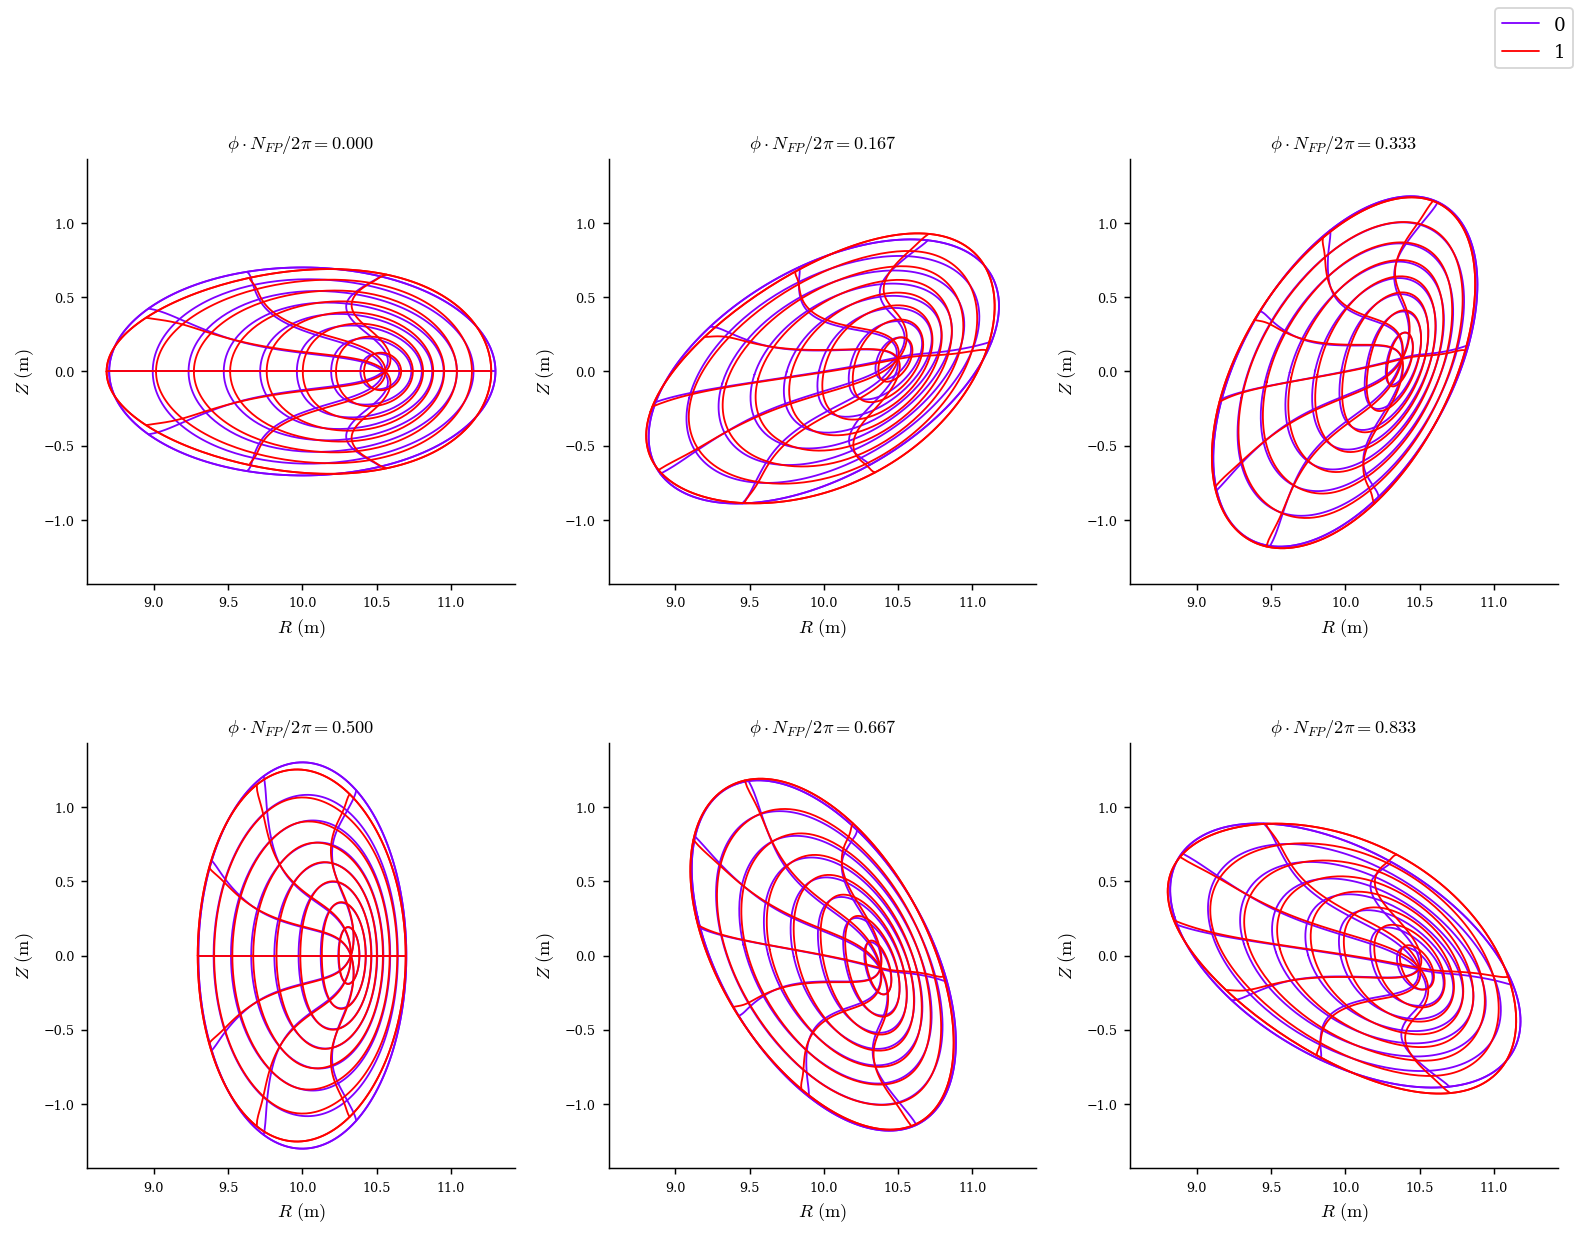

In [11]:
desc.plotting.plot_comparison([eq0, eq1]);

## Comparing growth rates of the initial and optimized equilibria

surf number 0 done!
surf number 1 done!
surf number 2 done!
surf number 3 done!
surf number 4 done!
surf number 5 done!
surf number 6 done!
Growth rate calculation finished!


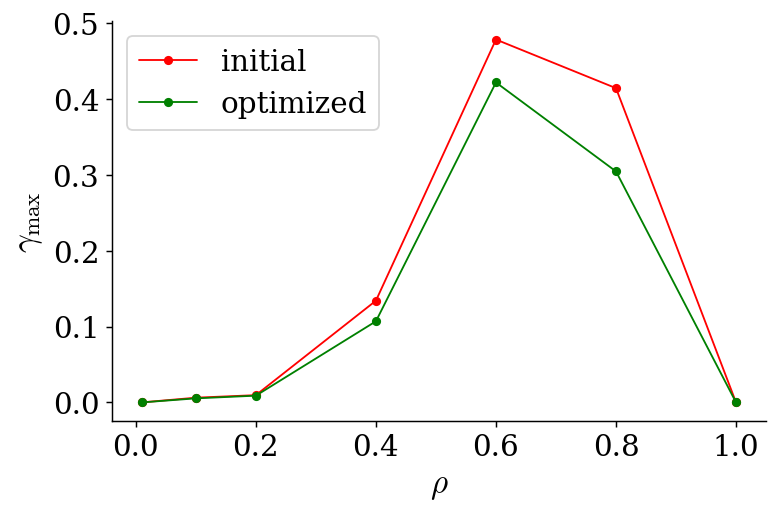

In [12]:
# Flux surfaces on which to evaluate ballooning stability
surfaces = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

nalpha = 8  # Number of field lines

# Field lines on which to evaluate ballooning stability
alpha = np.linspace(0, np.pi, nalpha, endpoint=False)

# Number of toroidal transits of the field line
nturns = 3

# Number of point along a field line in ballooning space
N0 = nturns * 200

# range of the ballooning coordinate zeta
zeta = np.linspace(-np.pi * nturns, np.pi * nturns, N0)

gamma_max1 = np.zeros(len(surfaces))

for j in range(len(surfaces)):
    rho = surfaces[j]

    grid = Grid.create_meshgrid(
        [rho, alpha, zeta], coordinates="raz", period=(np.inf, 2 * np.pi, np.inf)
    )
    ball_data0 = eq1.compute(["ideal ball gamma2"], grid=grid)

    gamma_max1[j] = np.max(ball_data0["ideal ball gamma2"])
    print(f"surf number {j} done!")

print("Growth rate calculation finished!")

plt.plot(np.array(surfaces), gamma_max0, "-or", ms=4)
plt.plot(np.array(surfaces), gamma_max1, "-og", ms=4)
plt.legend(["initial", "optimized"], fontsize=16)
plt.xlabel(r"$\rho$", fontsize=18)
plt.ylabel(r"$\gamma_{\mathrm{max}}$", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

## Relation to $\delta\! f$ gyrokinetics

The coefficients used by our ballooning solver are the exact same set used by any $\delta\! f$ gyrokinetic solver. Below we will specify the list and plot seven coefficients used by the GX gyrokinetics solver

$$ \mathrm{gradpar} = \mathbf{b}\cdot \mathbf{\nabla}\zeta $$
$$ g^{\alpha\alpha} = \lvert \mathbf{\nabla} \alpha \rvert^2 $$
$$ g^{\rho\alpha} = \mathbf{\nabla} \alpha \cdot \mathbf{\nabla} \rho $$
$$ g^{\rho\rho} = \lvert \mathbf{\nabla} \rho \rvert^2$$
$$ \mathrm{cvdrift} =  \frac{1}{B^3}[\mathbf{b} \times (\mathbf{b}\cdot \mathbf{\nabla}\mathbf{b})] \cdot \mathbf{\nabla} \alpha = \frac{1}{B^4}[\mathbf{b} \times \left(\mu_0 p + B^2/2\right)] \cdot \mathbf{\nabla} \alpha$$
$$ \mathrm{gbdrift} =  \frac{1}{B^2}(\mathbf{b} \times \mathbf{\nabla}B) \cdot \mathbf{\nabla} \alpha$$
$$ \mathrm{cvdrift_0} = \frac{1}{B^2}(\mathbf{b} \times \mathbf{\nabla}B) \cdot \mathbf{\nabla} \iota$$

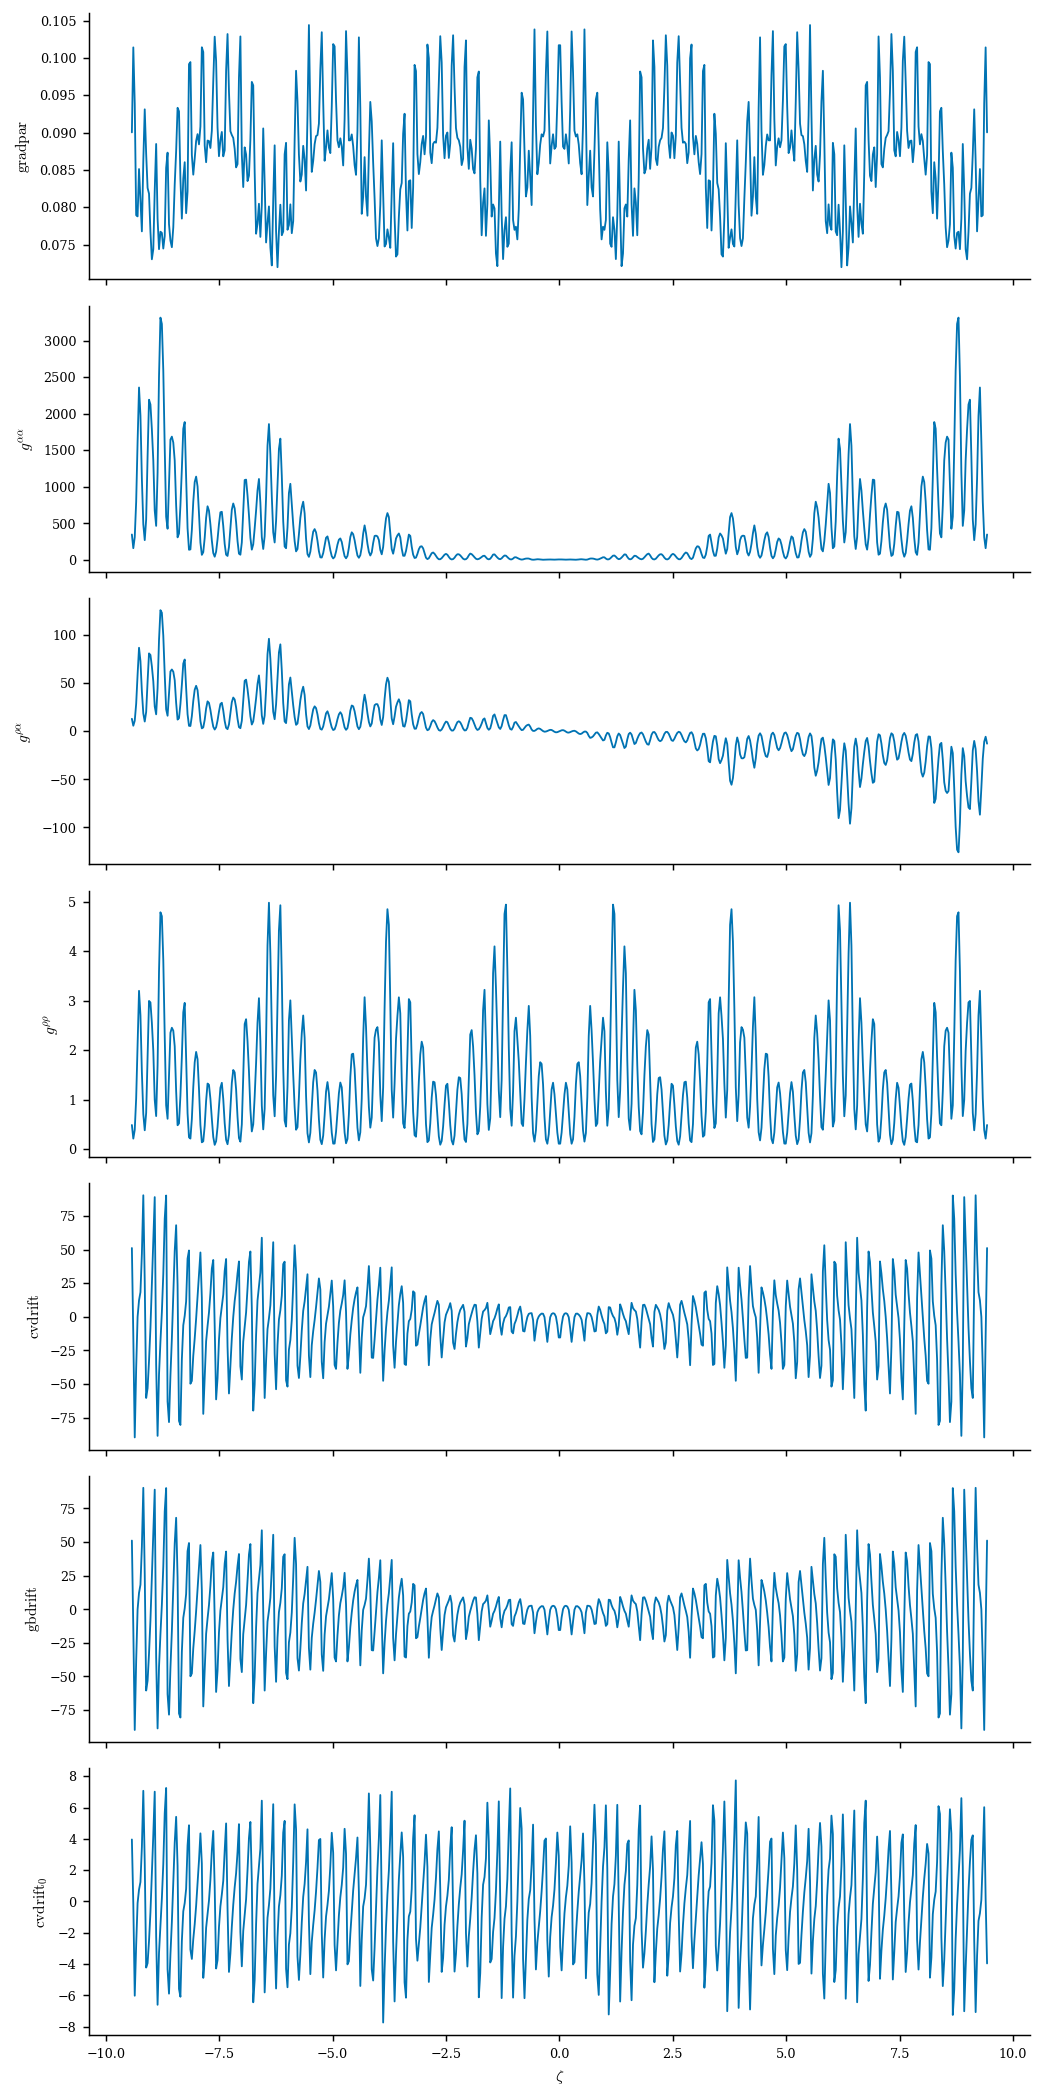

In [13]:
fig, ax = plt.subplots(7, sharex=True, figsize=(8, 16))

ax[0].plot(zeta, (ball_data0["B^zeta"] / ball_data0["|B|"])[::nalpha])
ax[0].set_ylabel("$\\mathrm{gradpar}$")
ax[1].plot(zeta, ball_data0["g^aa"][::nalpha])
ax[1].set_ylabel("$g^{\\alpha \\alpha}$")
ax[2].plot(zeta, ball_data0["g^ra"][::nalpha])
ax[2].set_ylabel("$g^{\\rho \\alpha}$")
ax[3].plot(zeta, ball_data0["g^rr"][::nalpha])
ax[3].set_ylabel("$g^{\\rho \\rho}$")
ax[4].plot(zeta, ball_data0["cvdrift"][::nalpha])
ax[4].set_ylabel("$\\mathrm{cvdrift}$")
ax[5].plot(zeta, ball_data0["gbdrift"][::nalpha])
ax[5].set_ylabel("$\\mathrm{gbdrift}$")
ax[6].plot(zeta, ball_data0["cvdrift0"][::nalpha])
ax[6].set_ylabel("$\\mathrm{cvdrift}_0$")
ax[6].set_xlabel("$\zeta$");